In [1]:
import os
import sys
# SRC_DIR environment variable should be the absolute path to the 'multicopy-STR-genotyping' directory
sys.path.append(os.environ["SRC_DIR"])

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from multicopy_STR_genotyping import file_io

sns.set_context("poster")
%matplotlib inline

In [3]:
vcf = "../../../data/HG002/variants/ExpansionHunter/HG002.GRCh38.2x250_EH_full.vcf" # str: path to input vcf file                      
vcf_format = "ExpansionHunter" # str: which tool was used to genotype
sample = "HG002.GRCh38.2x250" # str: name of sample in vcf to analyse
set_cn = True # bool: set CN of loci manually (based on chromosome name)
gt_in_bp = False # bool: does the tool report genotypes in bp (True) or in number of repeat units (False)
strs_covered_by_haplotypes = "../../../data/HG002/regions/hg38_ver13_0boe_mononucleotides_union.bed" # str: path to bed with loci that are covered by the haplotypes provided by Q100
haplotype_str_length = "../../../data/HG002/variants/HG002_GRCh38_STR_lengths.csv" # str: path to csv with STR allele lengths based on Q100 haplotypes
comparison_file_out = "../../../results/HG002/2024-07-18_hg002_ExpansionHunter.csv" # None or str: path to write csv with comparison of STR allele lengths from vcf to Q100 STR allele lengths


In [4]:
def set_cn_manually(df):
    autosomes = [f"chr{i}" for i in range(1, 23)]
    df = df.assign(
        copy_number = lambda x: [2 if i in autosomes else 1 for i in x["chr"]]
    )
    return df

In [5]:
df_repeats, df_hg002 = file_io.dfs_from_vcf(filename=vcf, samples=[sample], vcf_format=vcf_format)
print(df_repeats.shape, df_hg002.shape)

df_covered_repeats = pd.read_csv(strs_covered_by_haplotypes, sep="\t", names=["chr", "start", "end", "period", "unit"])
df_covered_repeats = df_covered_repeats.assign(
            str_id = np.array([f"{chrom}_{start + 1}" for chrom, start in zip(df_covered_repeats.chr, df_covered_repeats.start)])
)

df_covered_repeats = df_repeats[df_repeats["str_id"].isin(df_covered_repeats["str_id"])]

df_hg002 = df_hg002.merge(
    df_covered_repeats[["str_id", "chr", "start", "end", "period", "unit", "ref"]], on="str_id", how="inner"
)

if set_cn:
    df_hg002 = set_cn_manually(df_hg002)

print(df_covered_repeats.shape, df_hg002.shape)

df_hg002


(1659608, 7) (1659608, 5)
(1624108, 7) (1624108, 11)


,sample,str_id,copy_number,frequencies,genotype,chr,start,end,period,unit,ref
0,HG002.GRCh38.2x250,chr1_588068,2,32,"[4, 4]",chr1,588068,588079,3,CCT,4
1,HG002.GRCh38.2x250,chr1_589245,2,37,"[6, 6]",chr1,589245,589256,2,TC,6
2,HG002.GRCh38.2x250,chr1_590659,2,65,"[3, 3]",chr1,590659,590670,4,AAAT,3
3,HG002.GRCh38.2x250,chr1_590969,2,62,"[4, 4]",chr1,590969,590984,4,AAAC,4
4,HG002.GRCh38.2x250,chr1_591734,2,59,"[20, 175]",chr1,591734,591751,1,A,18
...,...,...,...,...,...,...,...,...,...,...,...
1624103,HG002.GRCh38.2x250,chrY_57188868,1,0,[11],chrY,57188868,57188878,1,A,11
1624104,HG002.GRCh38.2x250,chrY_57200838,1,0,[14],chrY,57200838,57200851,1,A,14
1624105,HG002.GRCh38.2x250,chrY_57201000,1,0,[20],chrY,57201000,57201019,1,A,20
1624106,HG002.GRCh38.2x250,chrY_57202381,1,0,[23],chrY,57202381,57202403,1,A,23


In [6]:
if gt_in_bp:
    df_hg002 = df_hg002.assign(
        illumina_region_len = lambda x: [sorted(gt) for gt in x["genotype"]],
        depth = lambda x: [sum(i.values()) for i in x["frequencies"]],
    )
else:
    df_hg002 = df_hg002.assign(
        illumina_region_len = lambda x: [sorted([k * j for k in i]) for i, j in zip(x["genotype"], x["period"])],
        depth = lambda x: x["frequencies"],
    )
    
df_hg002

,sample,str_id,copy_number,frequencies,genotype,chr,start,end,period,unit,ref,illumina_region_len,depth
0,HG002.GRCh38.2x250,chr1_588068,2,32,"[4, 4]",chr1,588068,588079,3,CCT,4,"[12, 12]",32
1,HG002.GRCh38.2x250,chr1_589245,2,37,"[6, 6]",chr1,589245,589256,2,TC,6,"[12, 12]",37
2,HG002.GRCh38.2x250,chr1_590659,2,65,"[3, 3]",chr1,590659,590670,4,AAAT,3,"[12, 12]",65
3,HG002.GRCh38.2x250,chr1_590969,2,62,"[4, 4]",chr1,590969,590984,4,AAAC,4,"[16, 16]",62
4,HG002.GRCh38.2x250,chr1_591734,2,59,"[20, 175]",chr1,591734,591751,1,A,18,"[20, 175]",59
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1624103,HG002.GRCh38.2x250,chrY_57188868,1,0,[11],chrY,57188868,57188878,1,A,11,[11],0
1624104,HG002.GRCh38.2x250,chrY_57200838,1,0,[14],chrY,57200838,57200851,1,A,14,[14],0
1624105,HG002.GRCh38.2x250,chrY_57201000,1,0,[20],chrY,57201000,57201019,1,A,20,[20],0
1624106,HG002.GRCh38.2x250,chrY_57202381,1,0,[23],chrY,57202381,57202403,1,A,23,[23],0


In [7]:
df_strs_haplotypes = pd.read_csv(haplotype_str_length).assign(chr = lambda x: [i[0] for i in x["str_id"].str.split("_")])
df_strs_haplotypes

,str_id,region_len_ref,region_len_mat,region_len_pat,chr
0,chr1_588068,12,12.0,12.0,chr1
1,chr1_589245,12,12.0,12.0,chr1
2,chr1_590659,12,12.0,12.0,chr1
3,chr1_590969,16,16.0,16.0,chr1
4,chr1_591734,18,20.0,20.0,chr1
...,...,...,...,...,...
1695860,chrY_57188868,11,NaN,11.0,chrY
1695861,chrY_57200838,14,NaN,15.0,chrY
1695862,chrY_57201000,20,NaN,20.0,chrY
1695863,chrY_57202381,23,NaN,23.0,chrY


In [8]:
autosomes = "chr != 'chrX' and chr != 'chrY'"
X = "chr == 'chrX'"
Y = "chr == 'chrY'"

df_strs_haplotypes["haplo_region_len"] = [[] for i in range(len(df_strs_haplotypes))]

df_strs_haplotypes.loc[df_strs_haplotypes.eval(autosomes), "haplo_region_len"] = pd.Series([
    sorted([np.int64(i), np.int64(j)]) for i, j in zip(
        df_strs_haplotypes.loc[df_strs_haplotypes.eval(autosomes), "region_len_mat"], 
        df_strs_haplotypes.loc[df_strs_haplotypes.eval(autosomes), "region_len_pat"],)])

for i, j in zip(
        df_strs_haplotypes.loc[df_strs_haplotypes.eval(X), "haplo_region_len"],
        df_strs_haplotypes.loc[df_strs_haplotypes.eval(X), "region_len_mat"]):
    i.append(np.int64(j))
    
for i, j in zip(
        df_strs_haplotypes.loc[df_strs_haplotypes.eval(Y), "haplo_region_len"],
        df_strs_haplotypes.loc[df_strs_haplotypes.eval(Y), "region_len_pat"]):
    i.append(np.int64(j))
    
df_strs_haplotypes

,str_id,region_len_ref,region_len_mat,region_len_pat,chr,haplo_region_len
0,chr1_588068,12,12.0,12.0,chr1,"[12, 12]"
1,chr1_589245,12,12.0,12.0,chr1,"[12, 12]"
2,chr1_590659,12,12.0,12.0,chr1,"[12, 12]"
3,chr1_590969,16,16.0,16.0,chr1,"[16, 16]"
4,chr1_591734,18,20.0,20.0,chr1,"[20, 20]"
...,...,...,...,...,...,...
1695860,chrY_57188868,11,NaN,11.0,chrY,[11]
1695861,chrY_57200838,14,NaN,15.0,chrY,[15]
1695862,chrY_57201000,20,NaN,20.0,chrY,[20]
1695863,chrY_57202381,23,NaN,23.0,chrY,[23]


In [9]:
df_comparison = (
    df_strs_haplotypes[["str_id", "haplo_region_len"]]
        .merge(df_hg002[["str_id", "illumina_region_len", "depth", "copy_number", "period"]], on="str_id", how="inner")
        .assign(
            match = lambda x: x["haplo_region_len"] == x["illumina_region_len"],
        )
)

df_comparison

,str_id,haplo_region_len,illumina_region_len,depth,copy_number,period,match
0,chr1_588068,"[12, 12]","[12, 12]",32,2,3,True
1,chr1_589245,"[12, 12]","[12, 12]",37,2,2,True
2,chr1_590659,"[12, 12]","[12, 12]",65,2,4,True
3,chr1_590969,"[16, 16]","[16, 16]",62,2,4,True
4,chr1_591734,"[20, 20]","[20, 175]",59,2,1,False
...,...,...,...,...,...,...,...
1624103,chrY_57188868,[11],[11],0,1,1,True
1624104,chrY_57200838,[15],[14],0,1,1,False
1624105,chrY_57201000,[20],[20],0,1,1,True
1624106,chrY_57202381,[23],[23],0,1,1,True


In [10]:
if comparison_file_out:
    df_comparison.to_csv(comparison_file_out, index=False)

In [11]:
n_wrong = df_comparison.loc[~df_comparison["match"]].shape[0]
n_total = df_comparison.shape[0]

print(f"n correct: {n_total - n_wrong}, n wrong: {n_wrong}, n total: {n_total}")
print("Overall accuracy:", (1 - (n_wrong / n_total)) * 100)

df_comparison.loc[~df_comparison["match"]]

n correct: 1343258, n wrong: 280850, n total: 1624108
Overall accuracy: 82.70743078662257


,str_id,haplo_region_len,illumina_region_len,depth,copy_number,period,match
4,chr1_591734,"[20, 20]","[20, 175]",59,2,1,False
19,chr1_621354,"[14, 14]","[14, 15]",19,2,1,False
23,chr1_626637,"[20, 20]","[19, 20]",42,2,1,False
27,chr1_639830,"[13, 13]","[0, 0]",24,2,1,False
29,chr1_641078,"[15, 15]","[15, 16]",49,2,1,False
...,...,...,...,...,...,...,...
1624092,chrY_57166593,[28],[25],0,1,1,False
1624093,chrY_57166848,[14],[16],0,1,1,False
1624095,chrY_57178821,[11],[12],0,1,1,False
1624104,chrY_57200838,[15],[14],0,1,1,False


In [12]:
min_depth = 15
max_depth = 85
query = f"depth / copy_number >= {min_depth} and depth / copy_number <= {max_depth}"

n_wrong = df_comparison.query(query).loc[~df_comparison.query(query)["match"]].shape[0]
n_total = df_comparison.query(query).shape[0]

print(f"n correct: {n_total - n_wrong}, n wrong: {n_wrong}, n total: {n_total}")
print("Overall accuracy:", (1 - (n_wrong / n_total)) * 100)

n correct: 1337494, n wrong: 276191, n total: 1613685
Overall accuracy: 82.88445390519216


In [13]:
df_plot = pd.DataFrame(
    np.concatenate([np.repeat([1, 2, 3, 4, 5, 6], 7).reshape(-1, 1), np.tile([1, 5, 5, 10, 10, 15, 15, 20, 20, 25, 25, 30, 30, 1e6], 6).reshape(-1, 2)], axis=1),
    columns=["period", "depth_lower", "depth_upper"]
)

accuracy = []
n = []
for row in df_plot.to_dict(orient="records"):
    selected_loci = (
        df_comparison
            .assign(depth = lambda x: x["depth"] / x["copy_number"])
            .query(f"depth >= {row['depth_lower']} and depth < {row['depth_upper']} and period == {row['period']}")["str_id"]
    )
    df_comparison_filt = df_comparison.loc[df_comparison["str_id"].isin(selected_loci)]
    n.append(df_comparison_filt.shape[0])
    accuracy.append((1 - (df_comparison_filt.loc[~df_comparison_filt["match"]].shape[0] / df_comparison_filt.shape[0])) * 100)

df_plot["n"] = n
df_plot["accuracy"] = accuracy
df_plot["depth"] = np.tile(["1-5", "5-10", "10-15", "15-20", "20-25", "25-30", "30-"], 6)

In [14]:
for name, data in df_plot.groupby("depth"):
    print(name, np.average(data["accuracy"], weights=data["n"]), data["n"].sum())
print()
for name, data in df_plot.groupby("period"):
    print(name, np.average(data["accuracy"], weights=data["n"]), data["n"].sum())



1-5 54.93910690121786 1478
10-15 45.716945996275605 2148
15-20 44.26129426129426 3276
20-25 54.33709449929478 8508
25-30 62.9131453434859 95608
30- 84.34412355083619 1487582
5-10 43.386515697375195 1943

1.0 74.74141010072148 839940
2.0 84.93952733022778 116995
3.0 91.85414470388565 133749
4.0 93.15838887207457 323798
5.0 92.29686005842362 152678
6.0 92.78375220920827 33383


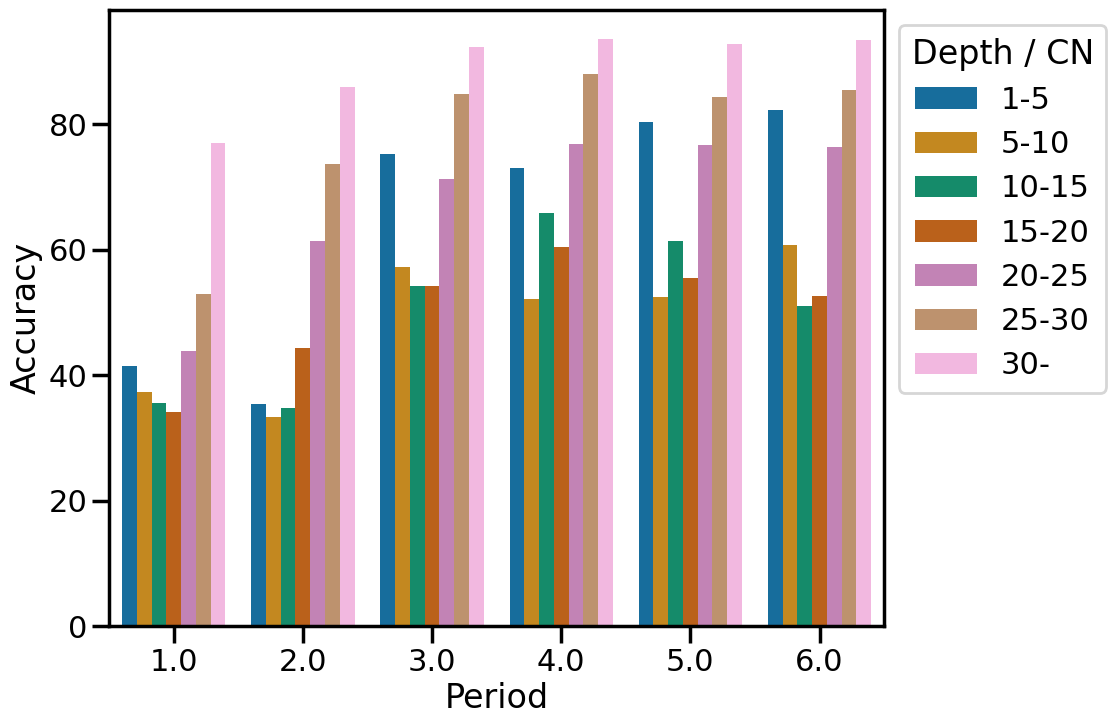

In [15]:
fig = plt.figure(figsize=(10, 8))

ax = sns.barplot(
    df_plot,
    x="period",
    y="accuracy",
    hue="depth",
    palette="colorblind"
)

ax.set(
    xlabel="Period",
    ylabel = "Accuracy"
)

_ = ax.get_legend().set(
    title="Depth / CN",
    bbox_to_anchor = (1, 1)
)

In [16]:
from scipy import ndimage

df_plot_density = (
    df_comparison
        .query("period >= 1 and period <= 6")
        .assign(depth = lambda x: x["depth"] / x["copy_number"])[["match", "period", "depth"]]
)

df_plot_smooth = (
    df_plot_density        
        .drop("period", axis=1)
        .groupby(["depth"], observed=True, as_index=False).agg(
            accuracy = ("match", lambda x: x.sum() / len(x)), 
            n_obs=("match", "count"))
        # .query(f"n_obs >= {min_obs}")
        
)

smooth = []
smooth = ndimage.gaussian_filter1d(df_plot_smooth["accuracy"], 3, mode="reflect")
df_plot_smooth = df_plot_smooth.assign(smooth = smooth)


df_plot_smooth_period = (
    df_plot_density
        .groupby(["period", "depth"], observed=True, as_index=False).agg(
            accuracy = ("match", lambda x: x.sum() / len(x)), 
            n_obs=("match", "count"))
        # .query(f"n_obs >= {min_obs}")
        
)

smooth = []
for group, data in df_plot_smooth_period.groupby(["period"]):
    current_smooth = ndimage.gaussian_filter1d(data["accuracy"], 3, mode="reflect")
    smooth.append(current_smooth)
df_plot_smooth_period = df_plot_smooth_period.assign(smooth = np.concatenate(smooth))

df_plot_smooth_period

,period,depth,accuracy,n_obs,smooth
0,1,0.0,0.583640,2176,0.467280
1,1,0.5,0.473684,133,0.462102
2,1,1.0,0.376543,162,0.453339
3,1,1.5,0.452381,84,0.443331
4,1,2.0,0.366972,109,0.433966
...,...,...,...,...,...
1166,6,123.0,1.000000,1,0.782550
1167,6,126.5,1.000000,1,0.785466
1168,6,127.0,1.000000,1,0.776288
1169,6,131.0,0.000000,1,0.762666


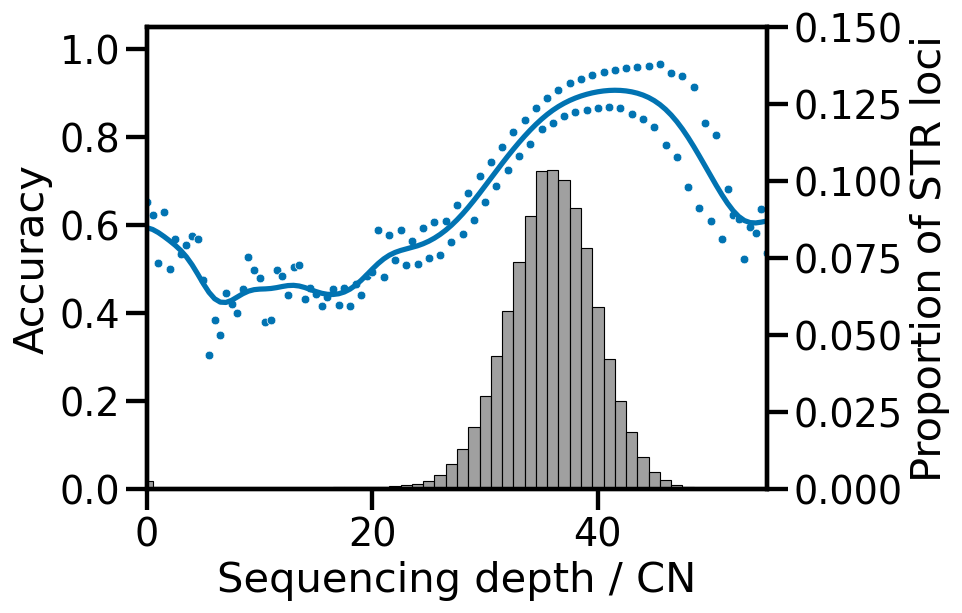

In [24]:
fig = plt.figure(dpi=125)

ax = sns.lineplot(
    df_plot_smooth,
    x = "depth",
    y = "smooth",
    color=sns.color_palette("colorblind")[0],
    # linewidth=2,
    legend=False
)

ax = sns.scatterplot(
    df_plot_smooth,
    x = "depth",
    y = "accuracy",
    color=sns.color_palette("colorblind")[0],
    s=25,
    ax = ax,
    legend=False
)

ax.set(
    xlabel = "Sequencing depth / CN",
    ylabel = "Accuracy",
    ylim = (0, 1.05),
    xlim = (0, 55)
)

ax2 = ax.twinx()
ax2 = sns.histplot(
    df_plot_density,
    x = "depth",
    discrete=True,
    stat="proportion",
    color="grey",
    ax=ax2,
)
ax2.set(
    ylabel="Proportion of STR loci",
    ylim=(0, 0.15),
)

plt.show()

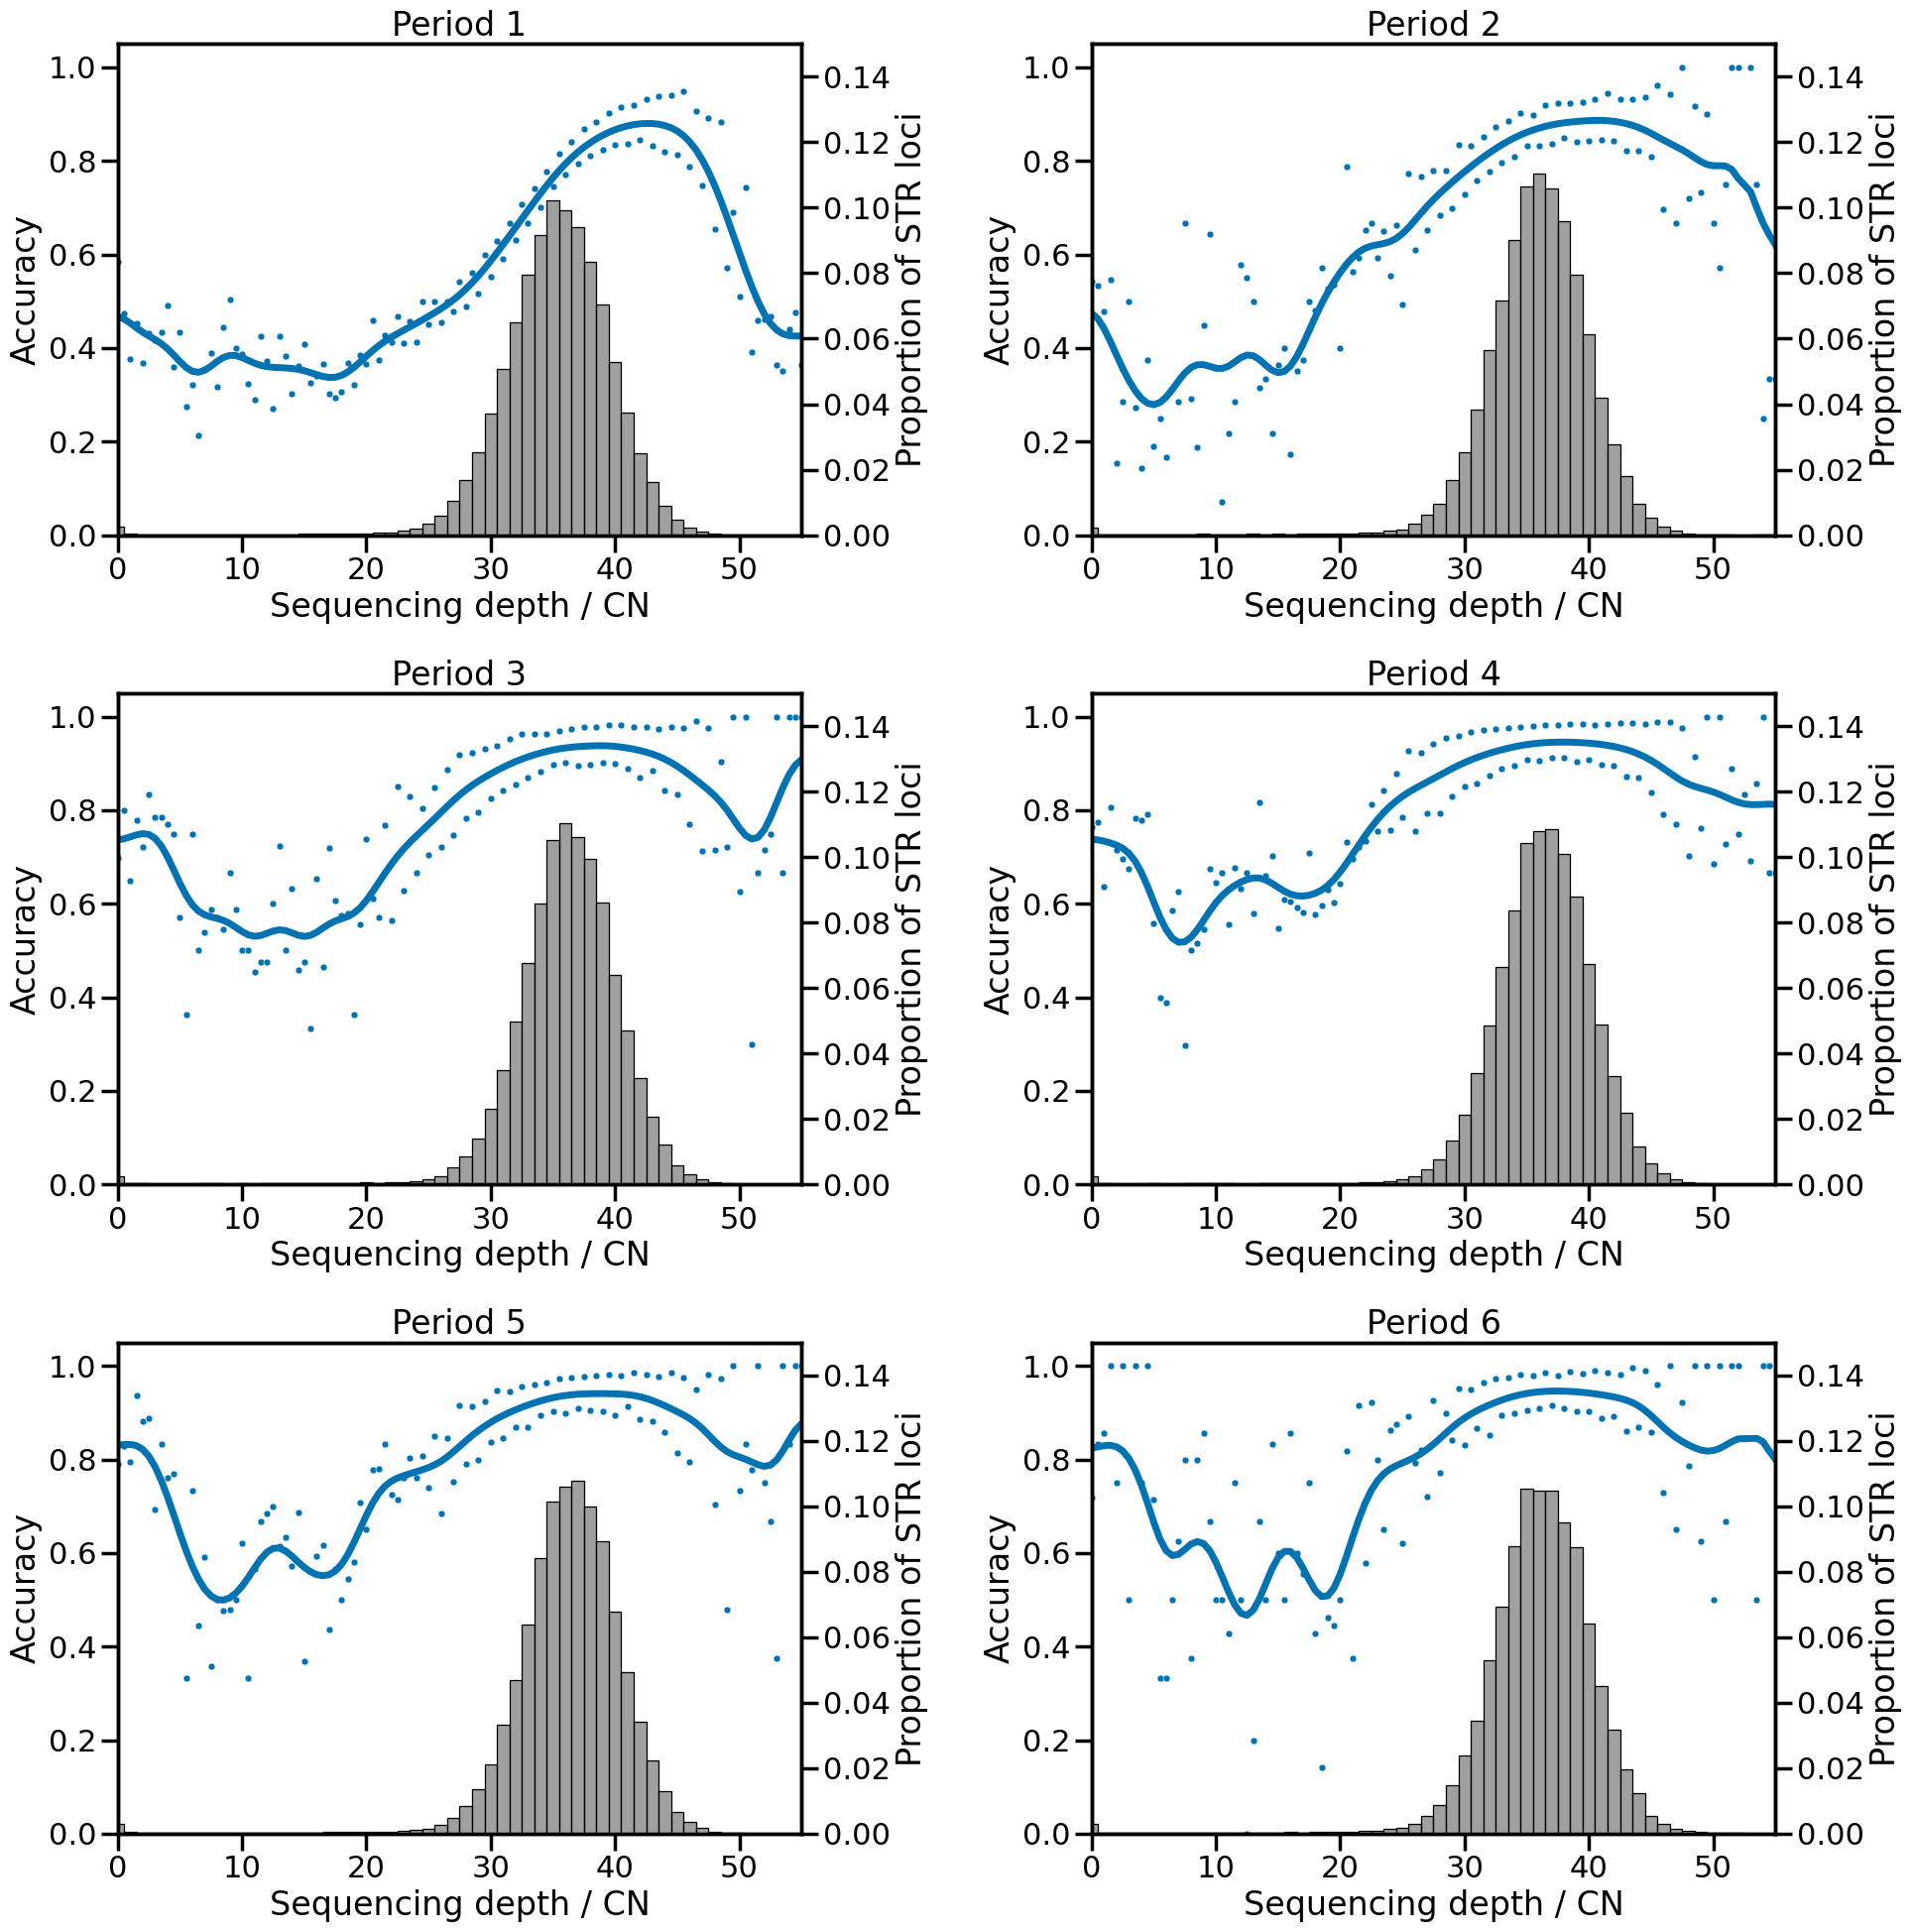

In [23]:
fig, axes = plt.subplots(3, 2, figsize=(20, 20))

for period, ax in zip(range(1, 7), axes.ravel()):
    df_subplot = (df_plot_smooth_period
                  .query(f"period == {period}"))

    ax = sns.lineplot(
        df_subplot,
        x = "depth",
        y = "smooth",
        color=sns.color_palette("colorblind")[0],
        linewidth=5,
        ax = ax,
    )

    ax = sns.scatterplot(
        df_subplot,
        x = "depth",
        y = "accuracy",
        color=sns.color_palette("colorblind")[0],
        s=25,
        ax = ax,
    )

    ax.set(
        title = f"Period {period}",
        xlabel = "Sequencing depth / CN",
        ylabel = "Accuracy",
        ylim = (0, 1.05),
        xlim = (0, 55)
    )
    
    ax2 = ax.twinx()
    ax2 = sns.histplot(
        df_plot_density.query(f"period == {period}"),
        x = "depth",
        discrete=True,
        stat="proportion",
        color="grey",
        ax=ax2,
    )
    
    ax2.set(
        ylabel="Proportion of STR loci",
        ylim=(0, 0.15),
    )

plt.tight_layout()